# INFO about this notebook
**Project Name:** My composer

**Author:** WeiZhi Tang (Work alone)

**Topic:** This project is about music generation. While ML works well in classification and regression task, can it still works when facing creative thing, like writting a song? Thus, this project aims at creating a composer through using proper models.

**Data:** All data is retrived from https://github.com/jukedeck/nottingham-dataset; All data files are midi file (format); Midi file is a kind of a file which records music score, parts, clef, instruments, notes, pitch, duration and so on and its file size is smaller than audio file (just about 100 kb for each file or slightly bigger according to its content; for data in this project, just about 100~300 kb for each file); Midi file is very different from audio file, it can not be play by common music players but it can imported by some softwares to be played, such as Musescore(free) and Sibelius(free or not free). In this project, I use Musescore to show music score and play midi file becasue the python lib I used, that "music21", make Musescore as default and I find that Musescore works better than Sibelius(free version);

**Data pre-processing(Cleanning and analysis):** In order to generate a song, it is necessary to set a key at first (like "C major", "G Major", "D minor"). Thus, if I want my models to generate a song, it is necessary to have enough midi files which have the same key. Firstly, I use music21 python lib to parse all the midi files to get their key and plot a graph to show their file numebr; Then, I find that number of "G major" Midi files is the max, so for this project, I will prefer generating a "G major" song. Then, I process all "G major" Midi files and get their notes(music notes) and make set of notes to record types of notes; Then, I make a dict of types of notes to map each type of notes to number. Then I transfer each note to number according to the dict. Then, **The most important** step is construct input sequences and output sequences; becasue I will use LSTM, for input sequences, I reshape it according to keras's document about LSTM input, which is (samples, timesteps, input_dim), and in order to make each note taken equally by model, I normalize them, and for output sequences, I use keras to_category to make 01 to resprent type of notes; Please see more detials in my code;

**Models:** Becasue music is not a simple prediction without any previous data info, music is about time so I have considered two models, that one is wavenet and one is LSTM; but, unfortunately, I failed to implement a beautiful model with wavenet structure; I then trun to try to use LSTM. LSTM will take previous data info to new coming data; and it works well when I use several LSTM layers with several dense layers to generate song. For loss fuction, because there are many types of notes, I use categorical_crossentropy; For optimizer, I have considered two which are RMSprop, Nadam, becasue rmsprop is appropriate for reccurent model and nadam is like adam rmspropr with Nesterov momentum. They works well in my project; Finally, I choose Nadam;

**Results:** I use the model to predict the notes and use music21 to put them to as a midi file. And I show a music score and I also play the midi file (please see more detials below). Then! I get my first song generated by models in my life. Amazing! HAHAHA! I will generate more midi and songs to put them in a directory when submiting.

**Discussion and Conclusion:** I generate a "G major" song in this project. I learn a lot from this projetc. For example, I learn how to process midi files (music21 document: https://web.mit.edu/music21/doc/usersGuide/), I learn about how to process sequences data, I leanr about LSTM (like timesteps, kinds of optimizers for recurrent model). Everything works ok but there is one point I'd like to mention is about pad_sequence() which make padding with 0 for each sequences, but it does matter the results becasue each file has very different length of notes sometimes, like that the min is 40 and the max is 200 so that the padding may destory the prediction. Thus, I comment it and combine each sequences without padding. It works well. Anyway, this project is meaningful, at least for me!

In [42]:
from music21 import *
import numpy as np
import pandas as pd
import os
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dropout,Dense
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Pre-processing ( Cleanning and Analysis)

In [43]:
#intial files
data_path = './data/MIDI/'
files = [file for file in os.listdir(data_path) if file.endswith(".mid")]

In [44]:
# midi = converter.parse(data_path+"ashover38.mid")
# midi.recurse()[1].tonic.name
# midi.recurse()[1].mode

In [45]:
#this is a list of key, each el represents for a key in a file
keys = [converter.parse(data_path+midi_file).recurse()[1] for midi_file in files] 

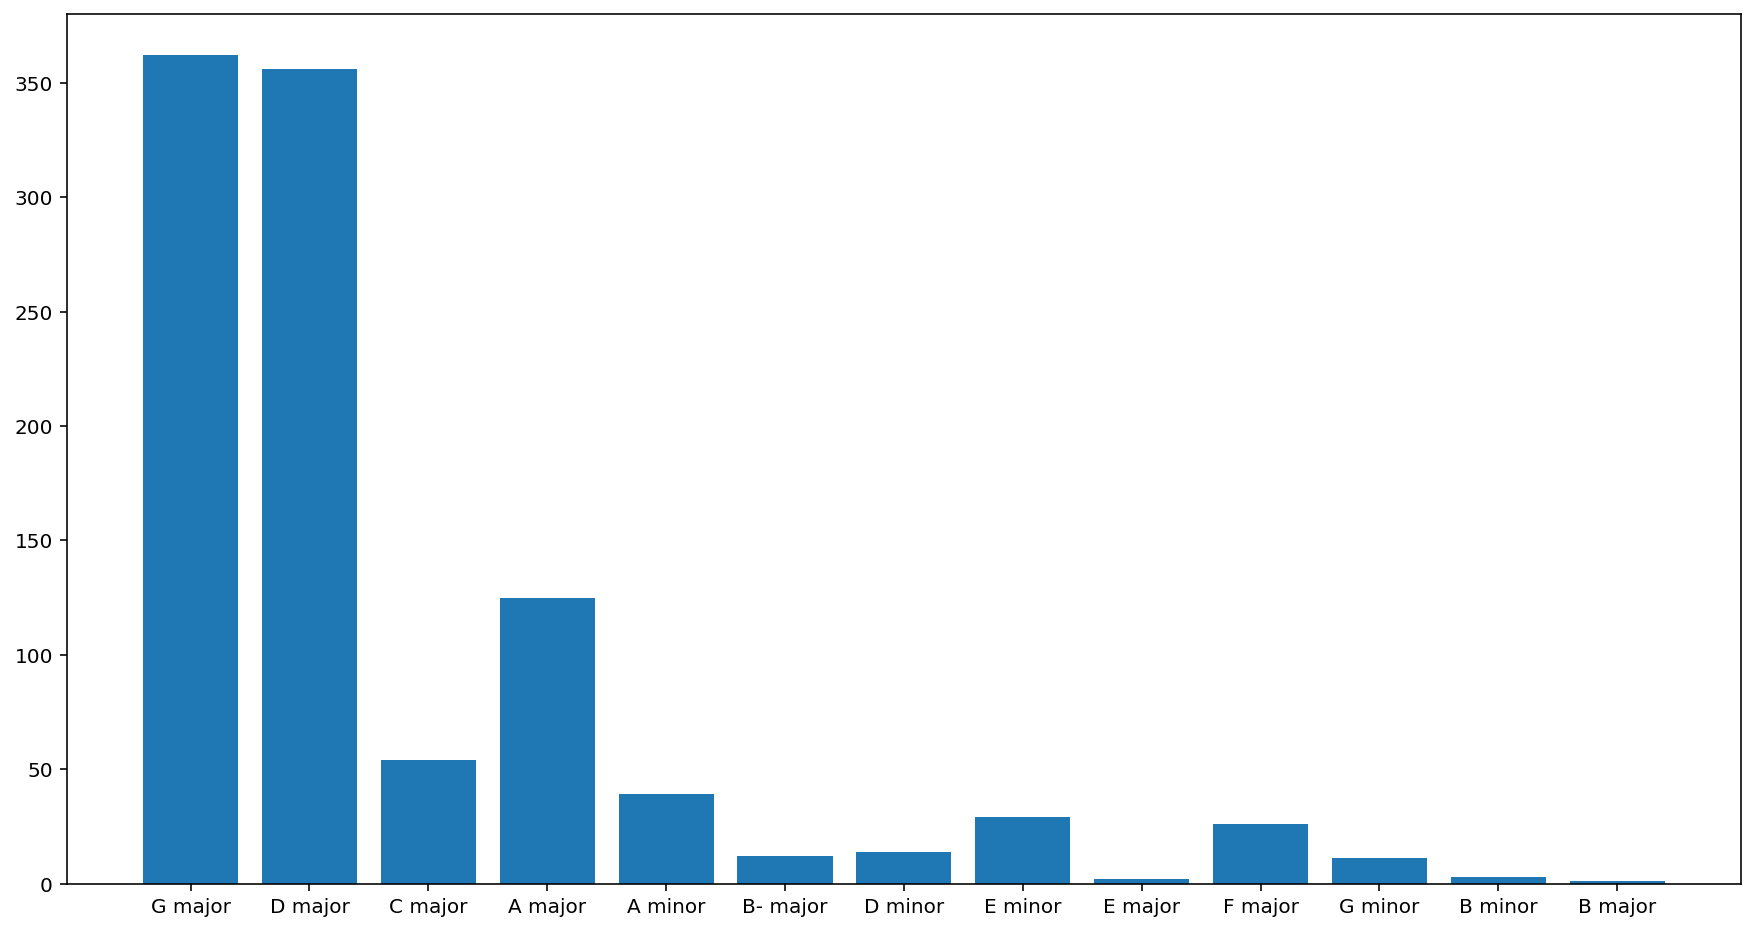

In [46]:
#find frequency of a certain key to determine whether I can get enough midi files for a certain key
keys_string = []
for el in keys:
    key_string = el.tonic.name+" " +el.mode
    keys_string.append(key_string)
keys_string = Counter(keys_string)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,8))
ax.bar(keys_string.keys(),keys_string.values())
plt.show()

In [47]:
#parse midi file depending on keyname(only parse if key == keyname)
#and return a note_arr which contains all note in a midi file
#keyname: Like 'G major'
def parse_midi(filePath,keyname): 
    note_arr=[]
    midi = converter.parse(filePath)
    key = midi.recurse()[1] #get key of a midi file
    if key.tonic.name+" " +key.mode == keyname: #check whether this key is what we want (keyname)
        for el in midi.parts[0].recurse():
            if isinstance(el,note.Note):
                note_arr.append(str(el.pitch)+" " + el.duration.type)
    return note_arr

In [48]:
# parse_midi(data_path+"ashover38.mid","D major")

In [49]:
#get all note_arr from G major music midi file
all_notes = []
for midi_file in files:
    note_arr = parse_midi(data_path+midi_file,"G major")
    if len(note_arr) > 0:
        all_notes.append(note_arr)


In [50]:
np.random.seed(1234)
#get appropriate number of note_arr and put them in part_notes
part_notes = np.array(all_notes)[np.random.choice(len(all_notes),70)]
#part_notes[0] will like ['D4 16th','C4 quarter']

In [52]:
#get all note to get a set of types of note; types is just like categories;
note_all = [el for note_arr in part_notes for el in note_arr]
note_all_set = set(note_all)
print("List len:", len(note_all))
print("Set len:", len(set(note_all)))

List len: 13007
Set len: 83


In [53]:
# map note string to number
note_all_dict = dict((j,i) for i,j in enumerate(note_all_set))
# print(note_all_dict)

# change part_notes to correspond number
part_notes_number = []
for i,note_arr in enumerate(part_notes):
    temp_note_arr = []
    for j,mynote in enumerate(note_arr):
        temp_note_arr.append(note_all_dict[mynote])
    part_notes_number.append(temp_note_arr)

In [54]:
#design input and out sequences

# sequences = pad_sequences(part_notes_number,padding="post") #pad sequence to make each sequence same len
sequences = part_notes_number

stride = 4*3  #this is timesteps for lstm
input_sequences = []
out_sequences = []
for seq in sequences:
    for i in range(len(seq)-stride):
        input_sequences.append(list(seq[i:i+stride]))   
        out_sequences.append(seq[i+stride])

# print(input_sequences)
# print("----"*10)
# print(out_sequences)
    
input_sequences = np.array(input_sequences)
out_sequences = np.array(out_sequences)

#reshape according to (samples, timesteps, input_dim)
input_sequences = np.reshape(input_sequences, (input_sequences.shape[0], stride,1))
#normalize note number (but I let each sequences - its mean)
input_sequences = (input_sequences-len(note_all_set)/2)/float(len(note_all_set)) 

#use 01 matrix to represent types(or categories)
out_sequences = to_categorical(out_sequences)

In [55]:
np.array(input_sequences).shape

(12167, 12, 1)

In [56]:
# len(note_all_set)

In [57]:
np.array(out_sequences).shape

(12167, 83)

## Model

In [60]:
#design modle
model = Sequential()
model.add(LSTM(450,input_shape=(input_sequences.shape[1],input_sequences.shape[2]),return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(450,input_shape=(input_sequences.shape[1],input_sequences.shape[2])))
model.add(Dropout(0.3))
# model.add(LSTM(450,input_shape=(input_sequences.shape[1],input_sequences.shape[2],return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(LSTM(450,input_shape=(input_sequences.shape[1],input_sequences.shape[2])))
# model.add(Dense(280,activation="relu"))
# model.add(Dropout(0.3))
model.add(Dense(328))
model.add(Dense(len(note_all_set)*2,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(len(note_all_set),activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='nadam') #rmsprop,nadam

# if "music_gene_model.h5" in os.listdir(): 
#     model = load_model("music_gene_model.h5")

In [61]:
#train model
from keras.callbacks import ModelCheckpoint
# I use callback function to save my model
model.fit(input_sequences, out_sequences, epochs=50, batch_size=200,callbacks=[ModelCheckpoint("music_gene_model.h5", monitor='loss', verbose=1, save_best_only=True,mode='min')])


Epoch 1/50
12167/12167 [==============================] - 44s 4ms/step - loss: 3.4901

Epoch 00001: loss improved from inf to 3.49009, saving model to music_gene_model.h5
Epoch 2/50
12167/12167 [==============================] - 43s 4ms/step - loss: 3.2185

Epoch 00002: loss improved from 3.49009 to 3.21853, saving model to music_gene_model.h5
Epoch 3/50
12167/12167 [==============================] - 41s 3ms/step - loss: 3.1973

Epoch 00003: loss improved from 3.21853 to 3.19731, saving model to music_gene_model.h5
Epoch 4/50
12167/12167 [==============================] - 42s 3ms/step - loss: 3.1790

Epoch 00004: loss improved from 3.19731 to 3.17902, saving model to music_gene_model.h5
Epoch 5/50
12167/12167 [==============================] - 44s 4ms/step - loss: 3.1608

Epoch 00005: loss improved from 3.17902 to 3.16075, saving model to music_gene_model.h5
Epoch 6/50
12167/12167 [==============================] - 43s 4ms/step - loss: 3.1327

Epoch 00006: loss improved from 3.16075 to

12167/12167 [==============================] - 42s 3ms/step - loss: 0.1505

Epoch 00048: loss improved from 0.15319 to 0.15050, saving model to music_gene_model.h5
Epoch 49/50
12167/12167 [==============================] - 42s 3ms/step - loss: 0.1459

Epoch 00049: loss improved from 0.15050 to 0.14590, saving model to music_gene_model.h5
Epoch 50/50
12167/12167 [==============================] - 42s 3ms/step - loss: 0.1524

Epoch 00050: loss did not improve from 0.14590


In [62]:
# note_all_dict
model.save("music_gene_model.h5")

## Prediction

In [107]:
#predict and generate notes

pred_note_arr = []
memory_notes = list(np.random.choice(len(note_all_set),stride)) #long-memory notes for prediction
memory_notes = (np.array(memory_notes)-len(note_all_set)/2)/float(len(note_all_set)) 
for i in range(120):
    pred_note = model.predict_classes(np.reshape(memory_notes, (1, stride, 1)))
    pred_note_arr.append(pred_note)
    memory_notes = list(memory_notes)
    memory_notes.pop(0)
    memory_notes.append((pred_note-len(note_all_set)/2)/float(len(note_all_set)))
# pred_note_arr    

In [108]:
#generate song through transforming number to note
note_all_dict_rev = dict((str(j),i) for i,j in note_all_dict.items())
# note_all_dict_rev

In [109]:
final_note_arr = []
for pred_note_numb in pred_note_arr:
    final_note_arr.append(note_all_dict_rev[str(pred_note_numb[0])])

In [110]:
# final_note_arr

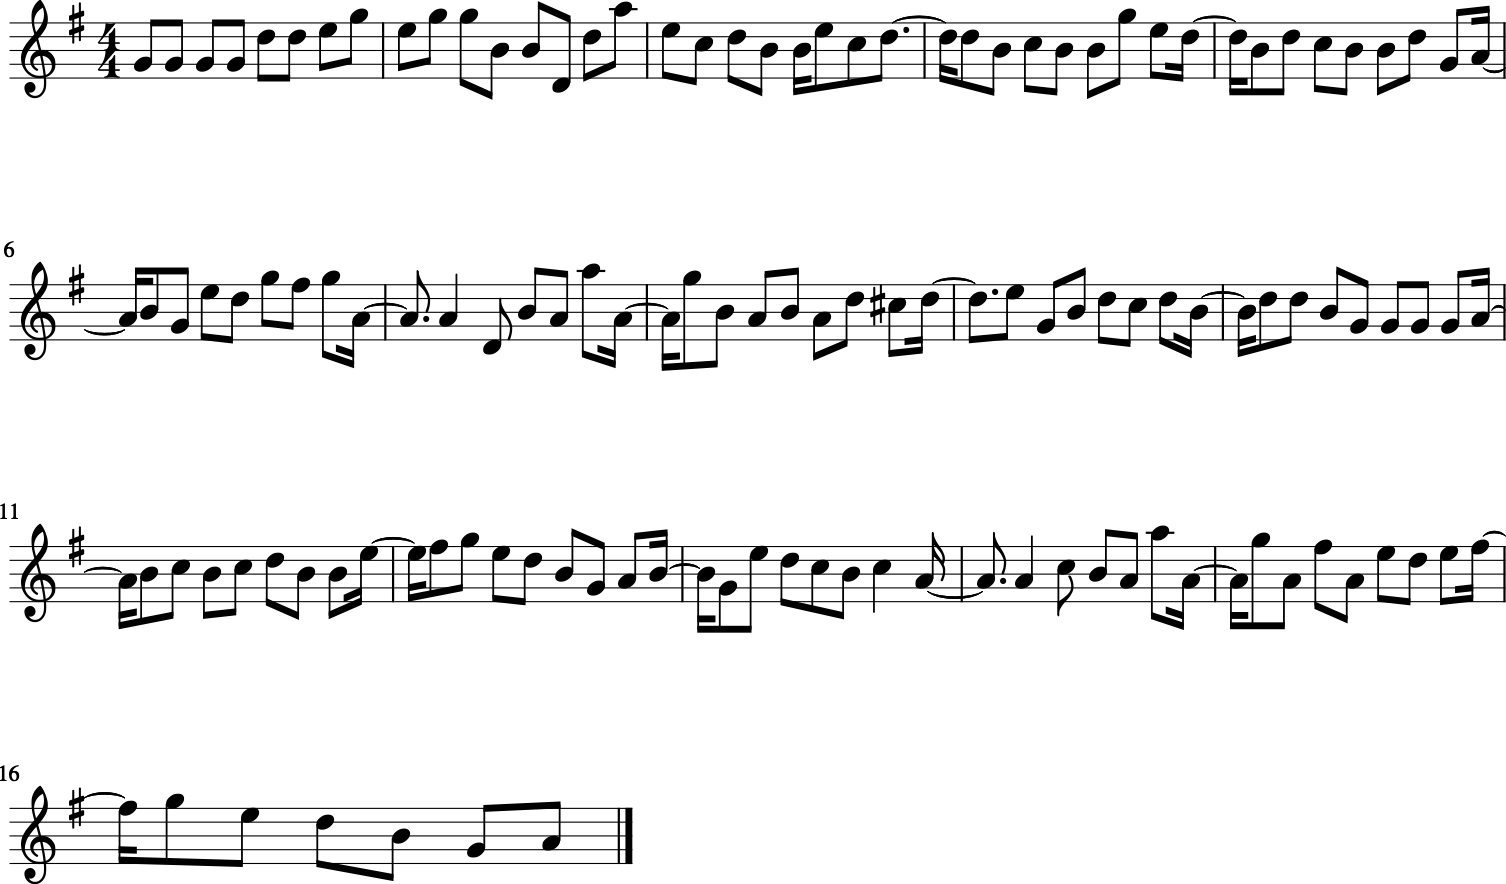

In [111]:
#crease a music stream
music_stream = stream.Stream()
#crease a part for melody
melody = stream.Part()
music_stream.append(melody)
#the music should be G major so set key as G major
melody.append(key.Key(tonic="G",mode="major")) 

#change all string note to real note
for el in final_note_arr: 
    name,duration = el.split(' ')
    melody.append(note.Note(name,type=duration))

music_stream.show()

In [112]:
music_stream.show('midi')

In [94]:
# music_stream.write("midi", "song03.midi")

'song03.midi'

In [ ]:
# for el in music_stream.recurse():
#     print(el)